In [1]:
! pip install snntorch



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.0 MB/s eta 0:00:00


In [2]:
! pip install pytorch-metric-learning --pre


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.0 MB/s eta 0:00:00


In [3]:
! pip install pytorch-metric-learning


In [4]:
from pytorch_metric_learning.losses import NTXentLoss
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import SelfSupervisedLoss


In [5]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-5-bd886847109b>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [6]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
#from lightly.loss import NTXentLoss


In [7]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'


dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:

# Define a transform
transform = transforms.Compose([
            #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            #transforms.RandomRotation(degrees=(0, 180)),
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])



In [9]:
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform )

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 161969197.14it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44831822.26it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4145023.67it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [10]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True )

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)



In [11]:
train_set_1, train_set_2 = torch.utils.data.random_split(mnist_train, [59800, 200])


In [12]:
train_1_loader = DataLoader(train_set_1, batch_size=batch_size, shuffle=True, drop_last=True)
train_2_loader = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, drop_last=True)

In [13]:
train_features, train_labels  = next(iter(train_loader))
train_features.shape

torch.Size([128, 1, 28, 28])

In [14]:
img = train_features[0].squeeze()
img.shape

torch.Size([28, 28])

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


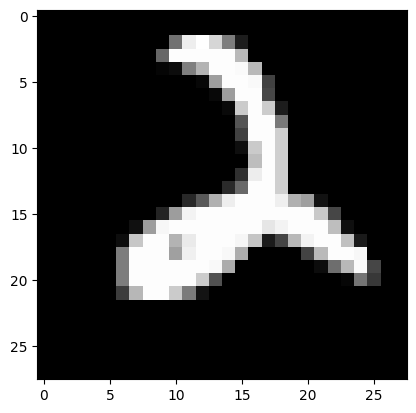

Label: 2


In [15]:
# Display image and label.
train_features, train_labels  = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


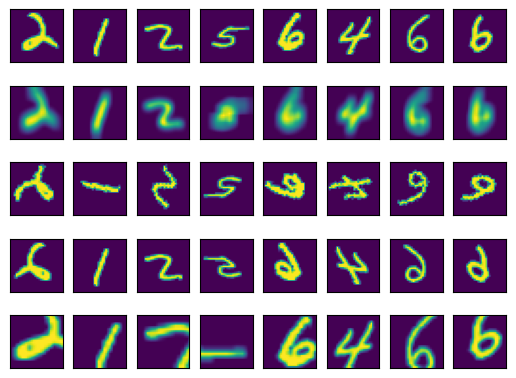

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

n = 8
fig, ax = plt.subplots(5, n)
g_transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = transforms.RandomRotation(degrees=(90, 180))
hf_transform = transforms.RandomHorizontalFlip(p=0.9)
rrc_transform = transforms.RandomResizedCrop(size=(32, 32))
crop_transform = transforms.CenterCrop((28, 28))

for i, img in enumerate(train_features[:n]):
    ax[0][i].imshow(img.squeeze())
    ax[1][i].imshow(g_transform(img).squeeze())
    ax[2][i].imshow(r_transform(img).squeeze())
    ax[3][i].imshow(hf_transform(img).squeeze())
    img_transformed = rrc_transform(img)
    img_cropped = crop_transform(img_transformed)
    ax[4][i].imshow(img_cropped.squeeze())

    for j in range(5):
        ax[j][i].get_xaxis().set_visible(False)
        ax[j][i].get_yaxis().set_visible(False)

plt.show()


In [17]:
# neuron and simulation parameters
#spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.9
num_steps = 30

In [18]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1,12, 5)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(12, 128, 5)
        self.lif2 = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(128*4*4,64)
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
          cur1 = F.max_pool2d(self.conv1(x), 2)
          spk1, mem1 = self.lif1(cur1, mem1)

          cur2 = F.max_pool2d(self.conv2(spk1), 2)
          spk2, mem2 = self.lif2(cur2, mem2)

          cur3 = self.fc1(spk2.view(batch_size, -1))
          spk3, mem3 = self.lif3(cur3, mem3)

          spk_rec.append(spk3)
          mem_rec.append(mem3)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)




In [19]:

'''class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(12, 128, 5)
        self.lif2 = snn.Leaky(beta=beta)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.lif3 = snn.Leaky(beta=beta)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 4 , 64)
        self.lif4 = snn.Leaky(beta=beta)
        self.relu4 = nn.ReLU(inplace=True)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x), 2)
            cur1 = self.bn1(cur1)
            spk1, mem1 = self.lif1(self.relu1(cur1), mem1)

            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            cur2 = self.bn2(cur2)
            spk2, mem2 = self.lif2(self.relu2(cur2), mem2)

            cur3 = F.max_pool2d(self.conv3(spk2), 2)
            cur3 = self.bn3(cur3)
            spk3, mem3 = self.lif3(self.relu3(cur3), mem3)

            cur4 = spk3.view(spk3.size(0), -1)
            cur4 = self.fc1(cur4)
            spk4, mem4 = self.lif4(self.relu4(cur4), mem4)

            spk_rec.append(spk4)
            mem_rec.append(mem4)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)'''


'class Net(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        # Initialize layers\n        self.conv1 = nn.Conv2d(1, 12, 5)\n        self.lif1 = snn.Leaky(beta=beta)\n        self.relu1 = nn.ReLU(inplace=True)\n        self.bn1 = nn.BatchNorm2d(12)\n\n        self.conv2 = nn.Conv2d(12, 128, 5)\n        self.lif2 = snn.Leaky(beta=beta)\n        self.relu2 = nn.ReLU(inplace=True)\n        self.bn2 = nn.BatchNorm2d(128)\n\n        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)\n        self.lif3 = snn.Leaky(beta=beta)\n        self.relu3 = nn.ReLU(inplace=True)\n        self.bn3 = nn.BatchNorm2d(256)\n\n        self.fc1 = nn.Linear(256 * 4 , 64)\n        self.lif4 = snn.Leaky(beta=beta)\n        self.relu4 = nn.ReLU(inplace=True)\n\n    def forward(self, x):\n        # Initialize hidden states and outputs at t=0\n        mem1 = self.lif1.init_leaky()\n        mem2 = self.lif2.init_leaky()\n        mem3 = self.lif3.init_leaky()\n        mem4 = self.lif4.i

In [20]:
net = Net().to(device)

In [21]:
'''data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_out, mem_out = net(data)
spk_out.shape'''

'data, targets = next(iter(train_loader))\ndata = data.to(device)\ntargets = targets.to(device)\n\nspk_out, mem_out = net(data)\nspk_out.shape'

In [22]:
#loss

loss_func_self_trip = SelfSupervisedLoss(losses.TripletMarginLoss(distance = CosineSimilarity(),
                                    reducer = ThresholdReducer(high=0.3),
                                    embedding_regularizer = LpRegularizer()))
loss_func_NTX = NTXentLoss()
loss_func_self_NTX = SelfSupervisedLoss(loss_func_NTX)
loss_func_triplet = losses.TripletMarginLoss(distance = CosineSimilarity(),
                                    reducer = ThresholdReducer(high=0.3),
                                    embedding_regularizer = LpRegularizer())

loss_func_self_con = SelfSupervisedLoss(losses.ContrastiveLoss(pos_margin=0, neg_margin=1))

In [23]:
#optimizer

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))


In [24]:

num_epochs = 3
loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    # Training loop
    for data, targets in iter(train_1_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        data_r = r_transform(data)
        data_g = g_transform(data)
        #data_c = crop_transform(rrc_transform(data))

        spk_rec_r, mem_rec_r = net(data_r)
        spk_rec_g, mem_rec_g = net(data_g)
        #spk_rec_c, mem_rec_c = net(data_c)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            loss_val += loss_func_self_NTX(mem_rec_r[step], mem_rec_g[step])

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())


        counter += 1
        if counter%100 ==0 :
          print(counter)


0
100
200
300
400
1
500
600
700
800
900
2
1000
1100
1200
1300
1400


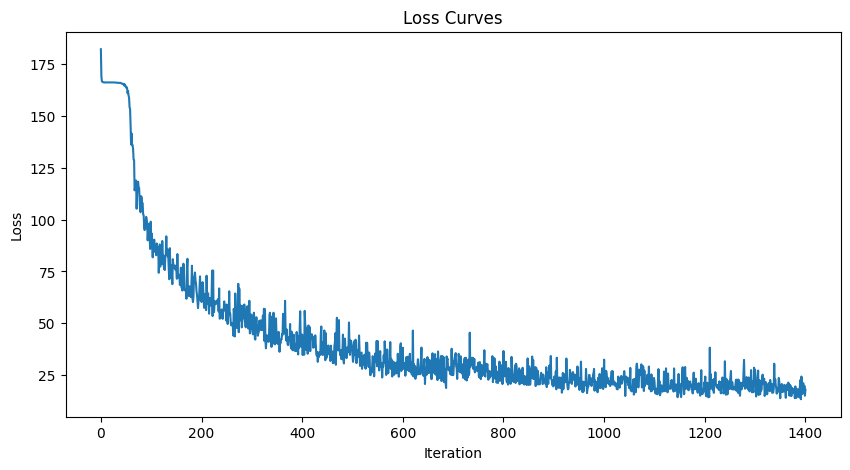

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

In [ ]:
l =[]
ll=[]
for test_data, test_targets in iter(test_loader):
      test_data = test_data.to(device)
      test_targets = test_targets.to(device)
      l.append(test_data.detach().cpu().numpy())
      ll.append(test_targets.detach().cpu().numpy())


In [ ]:
ll=np.array(ll)
ll = ll.reshape(78*128)
l=np.array(l)
l = l.reshape((78*128, 1, 28, 28))


In [ ]:
net.eval()
embeddings = []

with torch.no_grad():

            for test_data, test_targets in iter(test_loader):
              test_data = test_data.to(device)
              test_targets = test_targets.to(device)
              # Test set forward pass
              spk_out , mem_out = net(test_data)
              embeddings.append(mem_out.sum(dim=0).detach().cpu().numpy())
            embeddings = np.array(embeddings)
            print(embeddings.shape)
            embeddings = embeddings.reshape((78*128, 64))

(78, 128, 32)


In [ ]:
'''with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(train_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass

            test_spk, test_mem = net(test_data)'''


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize


In [ ]:
n_neighbors=10

num_examples=3

In [ ]:
X = embeddings

#X = test_mem.sum(dim=0).detach().numpy()
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)

distances, indices = nbrs.kneighbors(X)

#samples_idx = [9344 , 3688, 9069 , 7159]
samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)


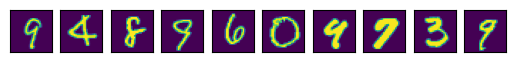

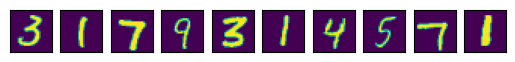

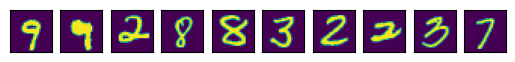

In [ ]:
for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors)
    #ax[0].imshow(np.transpose(test_data[samples_idx[i]].numpy(), (1, 2, 0)))
    #ax[0].set_title(classes[test_targets[samples_idx[i]]])
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j].imshow(np.transpose(l[k], (1, 2, 0)))
      ax[j].get_xaxis().set_visible(False)
      ax[j].get_yaxis().set_visible(False)


      #ax[j].set_title(classes[ll[k]])

In [ ]:
'''test_mem = test_mem.cpu()
X = test_mem.sum(dim=0).detach().numpy()
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)

distances, indices = nbrs.kneighbors(test_mem.sum(dim=0).detach().numpy())

samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)'''


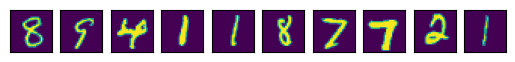

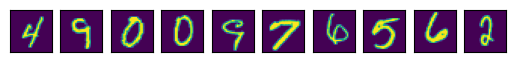

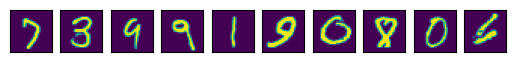

In [ ]:
for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors)
    #ax[0].imshow(np.transpose(test_data[samples_idx[i]].numpy(), (1, 2, 0)))
    #ax[0].set_title(classes[test_targets[samples_idx[i]]])
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j].imshow(np.transpose(l[k], (1, 2, 0)))
      ax[j].get_xaxis().set_visible(False)
      ax[j].get_yaxis().set_visible(False)


      #ax[j].set_title(classes[ll[k]])


In [ ]:
#plt.imshow(nbrs.kneighbors_graph(X).toarray())

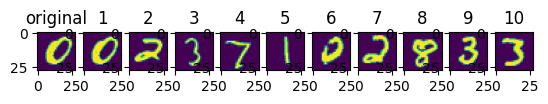

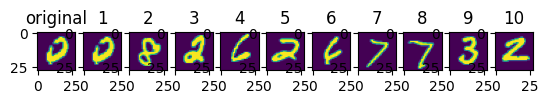

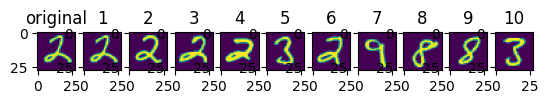

In [ ]:
test_data = test_data.cpu()
for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors+1)
    ax[0].imshow(test_data.squeeze()[samples_idx[i]])
    ax[0].set_title('original')
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j+1].imshow(test_data.squeeze()[k])
      ax[j+1].set_title(j+1)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [26]:
#Define Network

class Classifier(nn.Module):
    def __init__(self, backbone , latent_dim, projection_dim):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        #for param in backbone.parameters():
           #param.requires_grad = False

        # create a linear layer for our downstream classification model
        self.fc = self.fc = nn.Sequential(
            nn.Linear(latent_dim, projection_dim, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            #nn.Linear(projection_dim, projection_dim, bias=False),
            #nn.BatchNorm1d(128)
        )

    def forward(self, x):
        spk , mem = self.backbone(x)
        y_hat = self.fc(mem)
        return y_hat

# Load the network onto CUDA if available
classifier = Classifier(net ,64 , 10).to(device)

In [27]:
classifier

Classifier(
  (backbone): Net(
    (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (lif1): Leaky()
    (conv2): Conv2d(12, 128, kernel_size=(5, 5), stride=(1, 1))
    (lif2): Leaky()
    (fc1): Linear(in_features=2048, out_features=64, bias=True)
    (lif3): Leaky()
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [29]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = net(data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [30]:
mse_loss = nn.MSELoss()
cosine_loss = torch.nn.CosineSimilarity(dim=0)
cross_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.002, betas=(0.9, 0.999))


In [31]:
num_epochs =30
loss_hist = []
test_loss_hist = []
counter = 0
test_acc_hist =[]
# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    iter_counter = 0
    train_batch = iter(train_2_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        classifier.train()
        mem_rec = classifier(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += cross_loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            classifier.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_mem = classifier(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += cross_loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
 # Test set forward pass
            test_acc = batch_accuracy(test_loader, classifier, num_steps)
            #print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
            test_acc_hist.append(test_acc.item())
# Test set

            '''# Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1'''

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [32]:
test_acc_hist

[0.18609775641025642,
 0.24018429487179488,
 0.2782451923076923,
 0.3152043269230769,
 0.34615384615384615,
 0.36388221153846156,
 0.382411858974359,
 0.398036858974359,
 0.4176682692307692,
 0.43960336538461536,
 0.4619391025641026,
 0.48487580128205127,
 0.4951923076923077,
 0.5027043269230769,
 0.5120192307692307,
 0.5243389423076923,
 0.5373597756410257,
 0.5543870192307693,
 0.5673076923076923,
 0.5794270833333334,
 0.5918469551282052,
 0.6059695512820513,
 0.6321113782051282,
 0.6596554487179487,
 0.6851963141025641,
 0.6956129807692307,
 0.7052283653846154,
 0.7132411858974359,
 0.7170472756410257,
 0.7199519230769231]

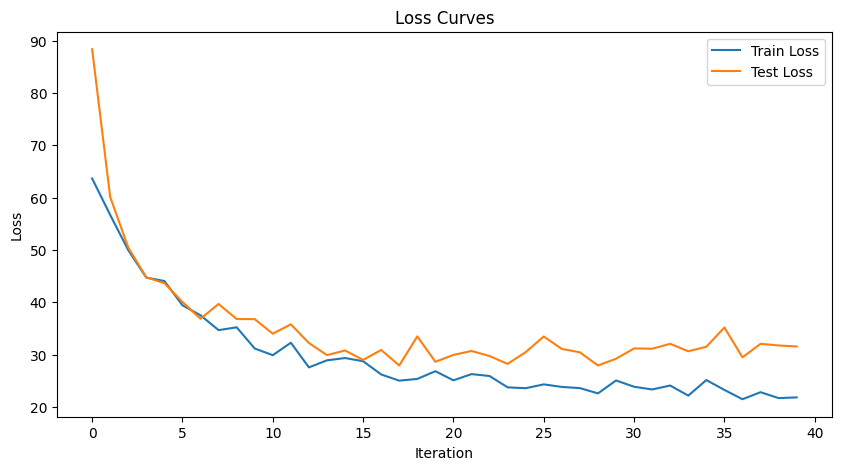

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
test_pred=test_mem.sum(dim=0).max(1)[1]
test_pred

tensor([7, 1, 5, 0, 6, 9, 2, 4, 1, 2, 2, 9, 7, 2, 9, 4, 3, 6, 4, 0, 4, 9, 2, 1,
        2, 1, 5, 5, 7, 9, 5, 4, 3, 9, 4, 5, 7, 1, 5, 3, 6, 9, 1, 4, 7, 2, 5, 0,
        3, 0, 1, 4, 2, 0, 7, 5, 5, 0, 7, 2, 6, 5, 3, 9, 1, 2, 9, 2, 9, 9, 5, 6,
        4, 1, 3, 3, 2, 9, 9, 0, 6, 0, 5, 2, 7, 5, 1, 6, 9, 3, 6, 2, 2, 3, 2, 9,
        0, 3, 7, 1, 6, 1, 2, 1, 9, 4, 0, 2, 4, 1, 5, 3, 0, 2, 0, 7, 1, 3, 1, 5,
        7, 1, 6, 5, 7, 0, 1, 9], device='cuda:0')

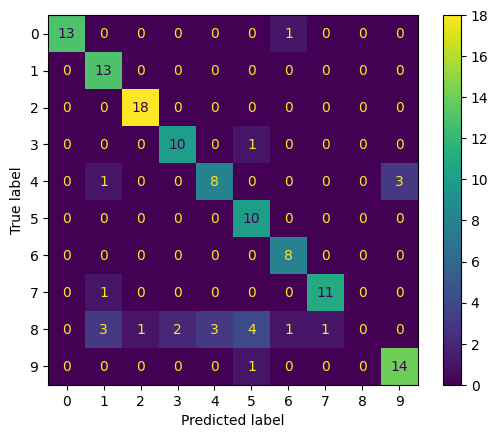

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets.cpu(), test_pred.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:

acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)

0.8203125
